In [1]:
import pandas as pd # for making data frames
import numpy as np # for creation of arrays
import math # for plotting CMC using log10 scale
from itertools import chain # allows lists to be combined

from sklearn.model_selection import train_test_split  # allows model to be tested on unseen data
from sklearn.ensemble import RandomForestRegressor # random forest model
from sklearn import tree # allows plot of decision tree to be made 
from sklearn.metrics import mean_squared_error, r2_score # statistics to score model 

import matplotlib.pyplot as plt # used to create plots
import seaborn as sns # used to create plots

import warnings # controls warnings
warnings.filterwarnings('ignore')

In [2]:
def random_forest_results(cmc_data, non_numerical, pred_all, log_cmc):
          
    '''
    
    random_forest_results:
    ----------------------
    
    A function that takes in a pandas data frame containing the measured CMC value for the surfactant and 
    features that can be used to predict the CMC values of different surfactant.
    
    Args:
    -----
    
    cmc_data: pandas data frame containing CMC values and other decriptors
    non_numerical: boolean used to show if the data being trained has non-numerical values contained in the 
    list (these will have to be converted into a numerical value) 
    pred_all: boolean used to describe if all data should be used in testing (True)
    log_cmc: boolean used to describe if training the model with CMC (False) or ln(CMC) (True)
    
    Returns:
    --------
    
    rf: random forest model of the data created by SKLearn 
    feature_list: list containing the names of the columns from the pandas data frame
    train_labels: measured CMC data used to train the random forest model
    test_labels: measured CMC data used to test the random forest model
    test_ind: index of the test data
    indices: index list
    predictions: predicted CMC values using the test features
    error: difference between predicted and measured value
    was_test: list of booleans to say if data was used to test the model (True) or to train it (False)
    
    '''
    
    # if the random forest is being trained on data with multiple surfactant groups, then the surfactant groups
    # need to be converted into values that can be used by the model so are put into a matrix of 1s and 0s,
    # corresponding to whether that data refers to a particular surfactant
    if non_numerical:  
        features = pd.get_dummies(data = cmc_data, columns = ["surfactant", "counter_ion"])
    else: # this is not necessary if these are not given as features
        features = cmc_data
    
    if log_cmc: # sets up to predict ln(CMC)
        true_cmc = np.array(cmc_data["ln(CMC)"])  # collects the ln(CMC) values and puts them into a numpy array
        features = features.drop("CMC", axis = 1) # both CMC and ln(CMC) dropped from feature list
        features = features.drop("ln(CMC)", axis = 1)
    else: # sets up to predict CMC
        true_cmc = np.array(cmc_data["CMC"]) # collects the CMC values and puts them into a numpy array
        features = features.drop("CMC", axis = 1) # actual CMC and ln(CMC) values are dropped 
        features = features.drop("ln(CMC)", axis = 1)

    feature_list = list(features.columns) # creates a list of the titles of columns from the pandas array

    features = np.array(features)         # puts training features into a numpy array
    indices = np.arange(len(features))    # creates numpy array of corresponding indices 
    
    # splits the data, CMC values and index lists into training and test data
    # random state is set so the random data is fixed each time program is run
    # features refers to all other data except CMC values used to predict values, labels are the true CMC values
    train_features, test_features, train_labels, test_labels, train_ind, test_ind = train_test_split(features, 
                                                                                                 true_cmc, 
                                                                                                 indices,
                                                                                                 test_size = 0.3, 
                                                                                                 random_state = 32)
    
    was_test = [] # returns boolean for each index to say if it was used as test data
    for ind in indices:
        if ind in train_ind:
            was_test.append(False)
        if ind in test_ind:
            was_test.append(True)
            
    rf = RandomForestRegressor(n_estimators = 200, random_state = 42, max_depth = 5) # create forest model 

    rf.fit(train_features, train_labels) # model is trained using the specified training data

    if not pred_all: # assigns features used for prediction                        
        true_cmc = test_labels
        features = test_features
        err_indices = test_ind
    else:
        err_indices = indices
    
    predictions = rf.predict(features)
    
    if log_cmc: # converts ln(CMC) values back to CMC values before statistics calculated
        predictions = ln_cmc_to_cmc(predictions)
        true_cmc = ln_cmc_to_cmc(true_cmc)
        train_labels = ln_cmc_to_cmc(train_labels)
        test_labels = ln_cmc_to_cmc(test_labels)
    
    error = abs(true_cmc - predictions)
    mse = mean_squared_error(true_cmc, predictions) # mean squared error of results
    rmse = np.sqrt(mean_squared_error(true_cmc, predictions)) # root mean squared error
    co_det = r2_score(true_cmc, predictions) # coefficient of determination
    mae = sum(abs(true_cmc-predictions)) / len(true_cmc) # mean absolute error 
    
    print("RMSE:", round(rmse, 2))
    print("Coefficient of determination:", round(co_det, 2))
    print("Mean Absolute Error:", round(mae, 2), "mM \n")
    
    return(rf, feature_list, train_labels, test_labels, test_ind, indices, predictions, error, was_test)

In [3]:
def plot_rf(rf, feature_list, file_name, save_fig):
                  
    '''
    
    plot_rf:
    --------
    
    A function that allows the random forest model to be visualised.
    
    Args:
    -----
    
    rf: random forest model of the data created by SKLearn 
    feature_list: list containing the names of the columns from the pandas data frame
    file_name: name of file to save figure as
    save_fig: boolean to say whether the figure should be saved
    
    Returns:
    --------
    
    plot of random forest trees
    
    '''
      
    fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4, 4), dpi = 500)
    tree.plot_tree(rf.estimators_[0], feature_names = feature_list, filled = True)
    
    if save_fig:
        fig.savefig("Plots/" + file_name, dpi = 500, bbox_inches = "tight")
        
    return

In [4]:
def separate_random_forest(cmc_data, start_test, end_test, non_numerical, show_data, log_cmc):
              
    '''
    
    separate_random_forest:
    ----------------------
    
    A function that takes in a pandas data frame containing the measured CMC value for the surfactant and 
    features that are used to predict the CMC values of different surfactant of a separate head group that has
    not been trained on using a random forest model.
    
    Args:
    -----
    
    cmc_data: pandas data frame containing CMC values and other decriptors 
    start_test: number giving the position of where the test data begins in the cmc_data dataframe
    end_test: number giving the position of where the test data ends in the cmc_data dataframe
    non_numerical: boolean used to show if the data being trained has non-numerical values contained in the 
    list (these will have to be converted into a numerical value) 
    show_data: prints out error information (Mean Absolute Percentage Error) if asked for
    log_cmc: boolean used to describe if training the model with CMC or ln(CMC)
    
    Returns:
    --------
    
    test_labels: measured CMC data used to test the random forest model
    indices: index of data 
    predictions: predicted CMC values using the test features
    
    '''
    
    # if the random forest is being trained on data with multiple surfactant groups, then the surfactant groups
    # need to be converted into values that can be used by the model so are put into a matrix of 1s and 0s,
    # corresponding to whether that data refers to a particular surfactant
    if non_numerical:  
        features = pd.get_dummies(data = cmc_data, columns = ["surfactant", "counter_ion"])
    else: # this is not necessary if these are not given as features
        features = cmc_data
    
    if log_cmc: # sets up to predict ln(CMC)
        true_cmc = np.array(cmc_data["ln(CMC)"])  # collects the ln(CMC) values and puts them into a numpy array
        features = features.drop("CMC", axis = 1) # both CMC and ln(CMC) dropped from feature list
        features = features.drop("ln(CMC)", axis = 1)
    else: # sets up to predict CMC
        true_cmc = np.array(cmc_data["CMC"])      # collects the CMC values and puts them into a numpy array
        features = features.drop("CMC", axis = 1) # actual CMC and ln(CMC) values are dropped 
        features = features.drop("ln(CMC)", axis = 1)
        
    feature_list = list(features.columns) # creates a list of the titles of columns from the pandas array
    
    features = np.array(features)      # puts all other features into a numpy array
    indices = np.arange(len(features)) # creates numpy array of corresponding indices

    # in this case, the test data is the unseen head group and the train data is all the rest of the data
    if start_test == 0: 
        test_features = features[0:(end_test+1)] # finds the corresponding features from the data frame excluding
        test_labels = true_cmc[0:(end_test+1)]   # the data for one head group which is tested for
        train_features = features[(end_test+1):]
        train_labels = true_cmc[(end_test+1):]
    elif end_test == (len(cmc_data) - 1):
        test_features = features[start_test:(end_test+1)]
        test_labels = true_cmc[start_test:(end_test+1)]
        train_features = features[0:start_test]
        train_labels = true_cmc[0:start_test]
    else:
        test_features = features[start_test:(end_test+1)]
        test_labels = true_cmc[start_test:(end_test+1)]
        
        train_feat1 = features[0:start_test]
        train_feat2 = features[(end_test+1):]
        train_features = np.concatenate((train_feat1, train_feat2), axis=0)
        
        train_lab1 = true_cmc[0:start_test]
        train_lab2 = true_cmc[(end_test+1):]
        train_labels = np.concatenate((train_lab1, train_lab2), axis=None)
    
    rf = RandomForestRegressor(n_estimators = 200, random_state = 42)  # create forest model
    rf.fit(train_features, train_labels) # fits model to all other head groups
    predictions = rf.predict(test_features) # predicts on unseen head group
    
    if log_cmc: # converts ln(CMC) values back to CMC values before statistics calculated
        predictions = ln_cmc_to_cmc(predictions)
        true_cmc = ln_cmc_to_cmc(true_cmc)
        train_labels = ln_cmc_to_cmc(train_labels)
        test_labels = ln_cmc_to_cmc(test_labels)
    
    mse = mean_squared_error(test_labels, predictions) # mean square error of results
    rmse = np.sqrt(mean_squared_error(test_labels, predictions)) # root mean square error 
    co_det = r2_score(test_labels, predictions) # coefficient of determination
    mae = sum(abs(test_labels-predictions)) / len(test_labels) # mean absolute error
    
    test_labels = list(test_labels)
    indices = list(indices)
    predictions = list(predictions)
    
    print("RMSE:", round(rmse, 2))
    print("Coefficient of determination:", round(co_det, 2))
    print("Mean Absolute Error:", round(mae, 2), "mM \n")
    
    return(test_labels, indices, predictions)

In [5]:
def rf_stats_average(cmc_data, split, non_numerical, log_cmc):
              
    '''
    
    rf_stats_average:
    -----------------
    
    A function that takes in the pandas dataframe and finds the average values of the statistics coefficient
    of determination, root mean square error and mean absolute error from a random forest model
    
    Args:
    -----
    
    cmc_data: pandas data frame containing CMC values and other decriptors 
    split: test/train split
    non_numerical: boolean used to show if the data being trained has different surfactant groups contained in the 
    list (these will have to be converted into a numerical value)
    log_cmc: boolean used to describe if training the model with CMC or ln(CMC)
    
    Returns:
    --------
    
    rmse_av: average value of the root mean square error
    co_det_av: average value of the coefficient of determination
    mae_av: average value of the mean absolute error
    
    '''
    
    rmse_list = []; co_det_list = []; mae_list = []
    rmse_total = 0; co_det_total = 0; mae_total = 0
    count = 0
    
    # if the random forest is being trained on data with multiple surfactant groups, then the surfactant groups
    # need to be converted into values that can be used by the model so are put into a matrix of 1s and 0s,
    # corresponding to whether that data refers to a particular surfactant
    if non_numerical:  
        features = pd.get_dummies(data = cmc_data, columns = ["surfactant", "counter_ion"])
    else: # this is not necessary if these are not given as features
        features = cmc_data
        
    if log_cmc: # sets up to predict ln(CMC)
        true_cmc = np.array(cmc_data["ln(CMC)"])  # collects the ln(CMC) values and puts them into a numpy array
        features = features.drop("CMC", axis = 1) # both CMC and ln(CMC) dropped from feature list
        features = features.drop("ln(CMC)", axis = 1)
    else: # sets up to predict CMC
        true_cmc = np.array(cmc_data["CMC"])      # collects the CMC values and puts them into a numpy array
        features = features.drop("CMC", axis = 1) # actual CMC and ln(CMC) values are dropped 
        features = features.drop("ln(CMC)", axis = 1)

    feature_list = list(features.columns) # creates a list of the titles of columns from the pandas array

    features = np.array(features)      # puts all other features into a numpy array
    indices = np.arange(len(features)) # creates numpy array of corresponding indices 
    
    for rs in range(100): # loops through 100 different test/train splits to get an average result
        
        # splits the x- and y-test data randomly according to the specified ratio
        train_feat, test_feat, train_label, test_label, train_ind, test_ind = train_test_split(features, true_cmc, 
                                                                                               indices,
                                                                                               train_size = split, 
                                                                                               random_state = rs)

        rf = RandomForestRegressor(n_estimators = 200, random_state = 42) # create forest model
        rf.fit(train_feat, train_label) # model is trained using the specified training data
        pred = rf.predict(test_feat) # predicts values from test data
        
        if log_cmc: # converts ln(CMC) values back to CMC values before statistics calculated
            pred = ln_cmc_to_cmc(pred)
            test_label = ln_cmc_to_cmc(test_label)
        
        mse = mean_squared_error(test_label, pred) # mean squared error of results
        rmse = np.sqrt(mean_squared_error(test_label, pred)) # root mean squared error 
        co_det = r2_score(test_label, pred) # coefficient of determination  (how well model predicts)
        mae = sum(abs(test_label-pred)) / len(test_label) # mean absolute error
        
        if co_det < 0.0: # assumes no correlation if below zero
            co_det = 0.0
            
        rmse_list.append(rmse); co_det_list.append(co_det); mae_list.append(mae)
        
        rmse_total += rmse # adds up the statistics values
        co_det_total += co_det
        mae_total += mae
        count += 1
        
    rmse_av = rmse_total / count # finds the average by dividing by the number of loops
    co_det_av = co_det_total / count
    mae_av = mae_total / count
    
    print("RMSE Mean: ", round(rmse_av, 2))
    print("Coeff of Det Mean: ", round(co_det_av, 2))
    print("MAE Mean: ", round(mae_av, 2))
    print("\n")
    print("RMSE Median: ", round(np.percentile(rmse_list, 50), 2)) # also prints percentiles
    print("Coeff of Det Median: ", round(np.percentile(co_det_list, 50), 2))
    print("MAE Median: ", round(np.percentile(co_det_list, 50), 2))
    print("\n")
    
    return(rmse_av, co_det_av, mae_av)

In [6]:
def plot_meas_pred(meas_max, pred_max, predictions, measured, index, was_test, func_group, plot_as_log, colours, 
                   file_name, save_fig):
              
    '''
    
    plot_meas_pred:
    ---------------
    
    A function that plots a graph of the predicted CMC against the measured CMC value and colour codes them based
    on the head group.
    
    Args:
    -----
    
    meas_max: maximum value of measured CMC data that can exclue some data to more clearly show the lower values
    pred_max: maximum value of predicted CMC data that will be shown on the graph
    predictions: CMC predicted values using the test features
    measured: measured CMC values corresponding to the test features that the prediction was made from
    index: index of the data used in the testing phase
    was_test: boolean list to say if point was used as test data (True) or train data (False)
    func_group: list of functional groups in the whole data set used
    plot_as_log: boolean to say if log10 scale should be used in plot
    colours: dictionary of the head groups and their corresponding colours for the plot
    file_name: name to save figure as
    save_fig: boolean to say if the figure should be saved
    
    Returns:
    --------
    
    plot of the predicted CMC value against the measured CMC value, colour coded based on head group
    
    '''
    
    # labels prevent head group showing up multiple times in legend
    CO2Na_label = 0; NH3Cl_label = 0; NMe3Br_label = 0; OSO3Na_label = 0; SO3Na_label = 0; PyBr_label = 0
    Ethoxylates_label = 0; Carboxylic_Acid_label = 0; NMe2NBzCl_label = 0; NH3Ac_label = 0; SO3H_label = 0

    f = plt.figure() # changes size of plot to make results more clear
    f.set_figwidth(7.5)
    f.set_figheight(6)
    
    new_meas = []; new_pred = []
    
    for ind, pred in enumerate(predictions): 
        meas = measured[ind] # for each predicted finds corresponding measured value
        
        if plot_as_log:
            meas = math.log10(meas)
            pred = math.log10(pred)
        
        new_meas.append(meas)
        new_pred.append(pred)
    
        if meas < meas_max and pred < pred_max: # only plots values below the specified max
            true_ind = index[ind] # finds the index of the data from the original data set 
            head_group = func_group[true_ind]  # index used to find corresponding head group
            test = was_test[true_ind] # changes marker, fill and size depending on whether the point is test or
            if test:                  # training data
                mark = "v"
                size = 36
                mfc = colours[head_group]
                mec = colours[head_group]
            else:
                mark = "o"
                size= 28
                mfc = "None"
                mec = colours[head_group]
 
            # checks if the individual head group has already been labelled in the legend and if not, plots the
            # data with the label corresponding to the head group
            if CO2Na_label == 0 and head_group == "CO2Na":  
                plt.scatter(meas, pred,s = size, facecolors = mfc, edgecolors = mec, label = head_group, 
                            marker = mark)
                CO2Na_label += 1
            elif NH3Cl_label == 0 and head_group == "NH3Cl":  
                plt.scatter(meas, pred, s = size, facecolors = mfc, edgecolors = mec, label = head_group, 
                            marker = mark)
                NH3Cl_label += 1
            elif NMe3Br_label == 0 and head_group == "NMe3Br":  
                plt.scatter(meas, pred, s = size, facecolors = mfc, edgecolors = mec, label = head_group, 
                            marker = mark)
                NMe3Br_label += 1
            elif OSO3Na_label == 0 and head_group == "OSO3Na":  
                plt.scatter(meas, pred, s = size, facecolors = mfc, edgecolors = mec, label = head_group, 
                            marker = mark)
                OSO3Na_label += 1
            elif SO3Na_label == 0 and head_group == "SO3Na":  
                plt.scatter(meas, pred, s = size, facecolors = mfc, edgecolors = mec, label = head_group, 
                            marker = mark)
                SO3Na_label += 1
            elif PyBr_label == 0 and head_group == "PyBr":  
                plt.scatter(meas, pred, s = size, facecolors = mfc, edgecolors = mec, label = head_group, 
                            marker = mark)
                PyBr_label += 1
            elif Ethoxylates_label == 0 and head_group == "Ethoxylates":  
                plt.scatter(meas, pred, s = size, facecolors = mfc, edgecolors = mec, label = head_group, 
                            marker = mark)
                Ethoxylates_label += 1
            elif Carboxylic_Acid_label == 0 and head_group == "Carboxylic Acid":  
                plt.scatter(meas, pred, s = size, facecolors = mfc, edgecolors = mec, label = head_group, 
                            marker = mark)
                Carboxylic_Acid_label += 1
            elif NMe2NBzCl_label == 0 and head_group == "NMe2NBzCl":  
                plt.scatter(meas, pred, s = size, facecolors = mfc, edgecolors = mec, label = head_group, 
                            marker = mark)
                NMe2NBzCl_label += 1
            elif SO3H_label == 0 and head_group == "SO3H":  
                plt.scatter(meas, pred, s = size, facecolors = mfc, edgecolors = mec, label = head_group, 
                            marker = mark)
                SO3H_label += 1
            elif NH3Ac_label == 0 and head_group == "NH3Ac":  
                plt.scatter(meas, pred, s = size, facecolors = mfc, edgecolors = mec, label = head_group, 
                            marker = mark)
                NH3Ac_label += 1
            else: # if it already has a label, it plots without one to avoid multiples in the legend
                plt.scatter(meas, pred, s = size, facecolors = mfc, edgecolors = mec, marker = mark)

    highest_num = max(max(new_meas), max(new_pred)) # finds largest value in both lists
    lowest_num = min(min(new_meas), min(new_pred))
    if highest_num > meas_max or highest_num > pred_max: # used to plot ideal line only below desired value
        highest_num = max(meas_max, pred_max)
    
    all_num_list = np.arange(lowest_num, highest_num, 1.0) # plots line where pred equals measured for comparison
    plt.plot(all_num_list, all_num_list, linestyle = "dashed", color = "black", linewidth = 0.5)

    if plot_as_log:
        y_lab = "Predicted log(CMC / mM)"
        x_lab = "Measured log(CMC / mM)"
    else:
        y_lab = "Predicted CMC / mM"
        x_lab = "Measured CMC / mM"
        
    plt.ylabel(y_lab, fontsize = 20)
    plt.xlabel(x_lab, fontsize = 20)
    
    plt.legend(bbox_to_anchor = (1.02, 1), loc = "upper left", borderaxespad = 0) 
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)

    if save_fig:
        plt.savefig("Plots/" + file_name, dpi = 500, bbox_inches = "tight")
    
    plt.show()
    
    return

In [7]:
def plot_meas_pred_test(meas_max, pred_max, predictions, measured, index, func_group, colours, file_name):
              
    '''
    
    plot_meas_pred_test:
    ---------------------
    
    A function that plots a graph of the predicted CMC against the measured CMC value for the values used as the 
    test set and colour codes them based on the head group.
    
    Args:
    -----
    
    meas_max: maximum value of measured CMC data that can exclue some data to more clearly show the lower values
    pred_max: maximum value of predicted CMC data that will be shown on the graph
    predictions: CMC predicted values using the test features
    measured: measured CMC values corresponding to the test features that the prediction was made from
    index: index of the data used in the testing phase
    func_group: list of functional groups in the whole data set used
    colours: dictionary of the head groups and their corresponding colours for the plot
    file_name: name to save figure as
    
    Returns:
    --------
    
    plot of the predicted CMC value against the measured CMC value, colour coded based on head group
    
    '''
    
    # labels prevent head group showing up multiple times in legend
    CO2Na_label = 0; NH3Cl_label = 0; NMe3Br_label = 0; OSO3Na_label = 0; SO3Na_label = 0; PyBr_label = 0
    Ethoxylates_label = 0; Carboxylic_Acid_label = 0; NMe2NBzCl_label = 0; NH3Ac_label = 0; SO3H_label = 0

    f = plt.figure() # changes size of plot to make results more clear
    f.set_figwidth(7.5)
    f.set_figheight(6)
    
    for ind, pred in enumerate(predictions): 
        meas = measured[ind] # for each predicted finds corresponding measured value
    
        if meas < meas_max and pred < pred_max: # only plots values below the specified max
            true_ind = index[ind] # finds the index of the data from the original data set 
            head_group = func_group[true_ind] # index used to find corresponding head group
 
            # checks if the individual head group has already been labelled in the legend and if not, plots the
            # data with the label corresponding to the head group
            if CO2Na_label == 0 and head_group == "CO2Na":  
                plt.scatter(meas, pred, s = 36, c = colours[head_group], label = head_group, marker = "v")
                CO2Na_label += 1
            elif NH3Cl_label == 0 and head_group == "NH3Cl":  
                plt.scatter(meas, pred, s = 36, c = colours[head_group], label = head_group, marker = "v")
                NH3Cl_label += 1
            elif NMe3Br_label == 0 and head_group == "NMe3Br":  
                plt.scatter(meas, pred, s = 36, c = colours[head_group], label = head_group, marker = "v")
                NMe3Br_label += 1
            elif OSO3Na_label == 0 and head_group == "OSO3Na":  
                plt.scatter(meas, pred, s = 36, c = colours[head_group], label = head_group, marker = "v")
                OSO3Na_label += 1
            elif SO3Na_label == 0 and head_group == "SO3Na":  
                plt.scatter(meas, pred, s = 36, c = colours[head_group], label = head_group, marker = "v")
                SO3Na_label += 1
            elif PyBr_label == 0 and head_group == "PyBr":  
                plt.scatter(meas, pred, s = 36, c = colours[head_group], label = head_group, marker = "v")
                PyBr_label += 1
            elif Ethoxylates_label == 0 and head_group == "Ethoxylates":  
                plt.scatter(meas, pred, s = 36, c = colours[head_group], label = head_group, marker = "v")
                Ethoxylates_label += 1
            elif Carboxylic_Acid_label == 0 and head_group == "Carboxylic Acid":  
                plt.scatter(meas, pred, s = 36, c = colours[head_group], label = head_group, marker = "v")
                Carboxylic_Acid_label += 1
            elif NMe2NBzCl_label == 0 and head_group == "NMe2NBzCl":  
                plt.scatter(meas, pred, s = 36, c = colours[head_group], label = head_group, marker = "v")
                NMe2NBzCl_label += 1
            elif SO3H_label == 0 and head_group == "SO3H":  
                plt.scatter(meas, pred, s = 36, c = colours[head_group], label = head_group, marker = "v")
                SO3H_label += 1
            elif NH3Ac_label == 0 and head_group == "NH3Ac":  
                plt.scatter(meas, pred, s = 36, c = colours[head_group], label = head_group, marker = "v")
                NH3Ac_label += 1
            else: # if it already has a label, it plots without one to avoid multiples in the legend
                plt.scatter(meas, pred, s = 36, c = colours[head_group], marker = "v")

    highest_num = max(max(measured), max(predictions)) # finds largest value in both lists
    if highest_num > meas_max or highest_num > pred_max: # used to plot ideal line only below desired value
        highest_num = max(meas_max, pred_max)
    
    all_num_list = np.arange(0, highest_num, 1.0) # plots line where predicted equals measured for comparison
    plt.plot(all_num_list, all_num_list, linestyle = "dashed", color = "black", linewidth = 0.5)

    plt.legend(bbox_to_anchor = (1.02, 1), loc = "upper left", borderaxespad = 0) 
    plt.xlabel("Measured CMC / mM", fontsize = 20) 
    plt.ylabel("Predicted CMC / mM", fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)

    #plt.savefig("Plots/" + file_name, dpi = 500, bbox_inches = "tight")
    plt.show()
    
    return

In [8]:
def plot_meas_pred_single(meas_max, pred_max, predictions, test_labels, test_ind, head_group, colours, file_name):
                  
    '''
    
    plot_meas_pred_single:
    ----------------------
    
    A function that plots a graph of the predicted CMC against the measured CMC value for only one specified head
    group
    
    Args:
    -----
    
    meas_max: maximum value of measured CMC data that can exclue some data to more clearly show the lower values
    pred_max: maximum value of predicted CMC data that will be shown on the graph
    predictions: CMC predicted values using the test features
    test_labels: measured CMC values corresponding to the test features that the prediction was made from
    test_ind: index of the data used in the testing phase
    head_group: head group being used in the plot
    colours: dictionary of the head groups and their corresponding colours for the plot  
    file_name: name to save figure as
    
    Returns:
    --------
    
    plot of the predicted CMC value against the measured CMC value for one head group
    
    '''
    
    f = plt.figure() # changes size of plot to make results more clear
    f.set_figwidth(7.5)
    f.set_figheight(6)
    
    # labels prevent head group showing up multiple times in legend
    data_point = 0  
    
    for ind, pred in enumerate(predictions): 
        meas = test_labels[ind] # for each predicted finds corresponding measured value
    
        if meas < meas_max and pred < pred_max: # only plots values below the specified max
            if data_point == 0: # used to check if the data has been labelled in the legend yet 
                                # if not, it plots with the label corresponding to the head group
                plt.scatter(meas, pred, s = 28, c = colours[head_group], label = head_group, marker = "v")
                data_point += 1
            else: # if it already has a label, it plots without one to avoid multiples in the legend
                plt.scatter(meas, pred, s = 28, c = colours[head_group], marker = "v")

    highest_num = max(max(test_labels), max(predictions)) # finds largest value in both lists
    if highest_num > meas_max or highest_num > pred_max: # used to plot ideal line only below desired value
        highest_num = max(meas_max, pred_max)
    
    all_num_list = np.arange(0, highest_num, 1.0) # plots line where predicted equals measured for comparison
    plt.plot(all_num_list, all_num_list, linestyle = "dashed", color = "black", linewidth = 0.5)
    
    plt.legend(fontsize = "x-large")
    plt.xlabel("Measured CMC / mM", fontsize = 20)
    plt.ylabel("Predicted CMC / mM", fontsize = 20) 
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)

    #plt.savefig("Plots/" + file_name, dpi = 500, bbox_inches = "tight")
    plt.show()
    
    return

In [9]:
def plot_var_importance(rf, feature_list, file_name):
              
    '''
    
    plot_var_importance:
    --------------------
    
    A function that creates a bar chart showing how important each of the variables used for predicting the CMC 
    value is for making an accurate prediction
    
    Args:
    -----
    
    rf: random forest model of the data created by SKLearn 
    feature_list: list of the names of the features used to predict the CMC values
    file_name: name to save figure as
    
    Returns:
    --------
    
    bar chart plot showing how important each of the variables used for predicting the CMC value is for making an
    accurate prediction
    
    '''
    
    importances = list(rf.feature_importances_) 
    # use forest to get the numerical feature importance (how much a particular feature is used to predict CMC)

    feature_importances = [(feat, round(importance, 2)) for feat, importance in zip(feature_list, importances)]
    # creates a tuple containing the feature and its importance 

    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # sort the feature importances by putting the most important first

    for pair in feature_importances: # prints out the sorted feature importance values
        print("Variable: {:20} Importance: {}".format(*pair))
        
    x_values = list(range(len(importances))) # creates a list of x-values to plot the features
    
    f = plt.figure() # changes size of plot to make results more clear
    f.set_figwidth(7.5)
    f.set_figheight(6)

    plt.bar(x_values, importances, orientation = "vertical") # creates bar chart of features and their importance
 
    plt.xticks(x_values, feature_list, rotation = 45, ha = "right", fontsize = 15) # labels features on graph
    plt.yticks(fontsize = 15)
    plt.ylabel("Importance", fontsize = 16)
    plt.xlabel("Variable", fontsize = 16)

    #plt.savefig("Plots/" + file_name, dpi = 500, bbox_inches = "tight")
    plt.show()
    
    return

In [10]:
def ln_cmc_to_cmc(ln_cmc):
              
    '''
    
    ln_cmc_to_cmc:
    --------------
    
    A function that takes in the predicted ln(CMC) values and converts them to CMC values
    
    Args:
    -----
    
    ln_cmc: list of predicted ln_cmc values
    
    Returns:
    --------
    
    acc_cmc: numpy array of CMC values
    
    '''
          
    cmc_list = []
    
    for val in ln_cmc:
        cmc = np.exp(val) # converts to CMC using the exponential
        cmc_list.append(cmc)
    
    acc_cmc = np.array(cmc_list)
        
    return(acc_cmc)

# Results

In [11]:
# reads in data containing CMC values and descriptors
cmc_data1 = pd.read_csv(open("Submit_Data/output_descriptors.csv"), delimiter = (",")) 

In [12]:
# removes all data that is not useful in the prediction of CMC values for the following reasons 

cmc_data1 = cmc_data1.drop("chain", axis = 1) # e.g. C8 or C8E1 and so is described in the other features used: 
                                              # carbon length, ethoxy length and number of aromatic rings

cmc_data1 = cmc_data1.drop("smiles", axis = 1) # all have different smiles strings so a numerical form using pandas
                                             # get_dummies will be different for each prediction so cannot be used
                                             # to make a prediction

cmc_data1 = cmc_data1.drop("head_smiles", axis = 1) # same as the head group which is already a feature

cmc_data1 = cmc_data1.drop("tail_smiles", axis = 1) # same as length of carbon chain which is already a feature

The data below was tested by first creating a random forest model for all the data. As with the linear regression, this further demonstrated that the ethoxylate group is predicted very poorly than all the other head groups tested. The data was then separated to exlcude this head group and another random forest model was performed on this data set.

### Collecting data sets for use in random forest model

In [13]:
func_group = []; true_cmc = []; log_cmc = []

carbon_len_all = []; ethoxy_length_all = []; aromatic_rings_all = []; counter_ion_all = []
MW_all = []; NVE_all = []; logP_all = []; chi0_all = []; bertzct_all = []
chi1_all = []; peoe_vsa6_all = []; labute_asa_all = []; molmr_all = []; wiener_index_all = []
zagreb_index1_all = []; zagreb_index2_all = []; walk_count_all = []; total_ic_all = []

func_group_sep = []; carbon_len_sep = []; aromatic_rings_sep = []; counter_ion_sep = []; cmc_sep = []
log_cmc_sep = []; MW_sep = []; NVE_sep = []; logP_sep = []; surfactant_sep = []; chi0_sep = []; bertzct_sep = []
chi1_sep = []; peoe_vsa6_sep = []; labute_asa_sep = []; molmr_sep = []; wiener_index_sep = []
zagreb_index1_sep = []; zagreb_index2_sep = []; walk_count_sep = []; total_ic_sep = []

for ind, row in cmc_data1.iterrows(): # reads in the rows of the data 
    
    func_group_i = row["func_group"]; carbon_len_i = row["carbon_len"]; ethoxy_len_i = row["ethoxy_len"]      
    aromatic_i = row["aromatic_rings"]; counter_ion_i = row["counter_ion"]; cmc_i = row["CMC"]                    
    log_cmc_i = np.log(cmc_i); mol_weight_i = row["MW"]; val_elec_i = row["NVE"]; logp_i = row["logP"]                  
    chi0_i = row["chi0"]; bertzct_i = row["bertzct"]; chi1_i = row["chi1"]; peoe_vsa6_i = row["peoe_vsa6"]
    labute_asa_i = row["labute_asa"]; molmr_i = row["molmr"]; wiener_index_i = row["wiener_index"]
    zagreb_index1_i = row["zagreb_index1"]; zagreb_index2_i = row["zagreb_index2"]
    walk_count_i = row["walk_count"]; total_ic_i = row["total_ic"]
        
    if func_group_i != "Ethoxylates": # collects all data excluding the ethoxylates and puts into lists 
        func_group_sep.append(func_group_i); carbon_len_sep.append(carbon_len_i)
        aromatic_rings_sep.append(aromatic_i); counter_ion_sep.append(counter_ion_i); cmc_sep.append(cmc_i)
        log_cmc_sep.append(log_cmc_i); MW_sep.append(mol_weight_i); NVE_sep.append(val_elec_i)
        logP_sep.append(logp_i); chi0_sep.append(chi0_i); bertzct_sep.append(bertzct_i); chi1_sep.append(chi1_i) 
        peoe_vsa6_sep.append(peoe_vsa6_i); labute_asa_sep.append(labute_asa_i); molmr_sep.append(molmr_i)
        wiener_index_sep.append(wiener_index_i); zagreb_index1_sep.append(zagreb_index1_i)
        zagreb_index2_sep.append(zagreb_index2_i); walk_count_sep.append(walk_count_i)
        total_ic_sep.append(total_ic_i)
        
    func_group.append(func_group_i); carbon_len_all.append(carbon_len_i)
    ethoxy_length_all.append(ethoxy_len_i); aromatic_rings_all.append(aromatic_i)
    counter_ion_all.append(counter_ion_i); true_cmc.append(cmc_i); log_cmc.append(log_cmc_i)
    MW_all.append(mol_weight_i); NVE_all.append(val_elec_i); logP_all.append(logp_i)
    chi0_all.append(chi0_i); bertzct_all.append(bertzct_i); chi1_all.append(chi1_i)
    peoe_vsa6_all.append(peoe_vsa6_i); labute_asa_all.append(labute_asa_i); molmr_all.append(molmr_i)
    wiener_index_all.append(wiener_index_i); zagreb_index1_all.append(zagreb_index1_i)
    zagreb_index2_all.append(zagreb_index2_i); walk_count_all.append(walk_count_i)
    total_ic_all.append(total_ic_i)
    
cmc_data1["ln_cmc"] = log_cmc # adds ln(CMC) to dataframe

### Distribution of CMC and ln(CMC) values

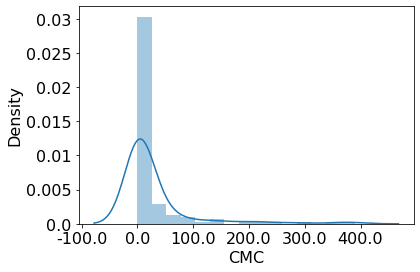

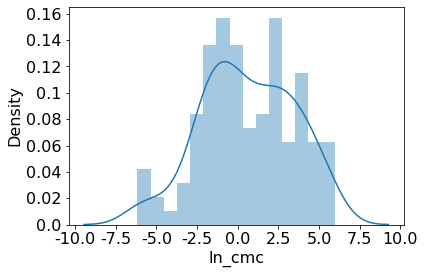

In [14]:
p = sns.distplot(cmc_data1.CMC, bins = 15)
_, ylabels = plt.yticks()
_, xlabels = plt.xticks()
p.set_yticklabels(p.get_yticks(), size = 16)
p.set_xticklabels(p.get_xticks(), size = 16)
p.set_xlabel(p.get_xlabel(), size = 16)
p.set_ylabel(p.get_ylabel(), size = 16)
#plt.savefig("Plots/cmc_hist", dpi = 500, bbox_inches = "tight")
plt.show()

p = sns.distplot(cmc_data1.ln_cmc, bins = 15)
_, ylabels = plt.yticks()
_, xlabels = plt.xticks()
p.set_yticklabels(p.get_yticks(), size = 16)
p.set_xticklabels(p.get_xticks(), size = 16)
p.set_xlabel(p.get_xlabel(), size = 16)
p.set_ylabel(p.get_ylabel(), size = 16)
#plt.savefig("Plots/ln_cmc_hist", dpi = 500, bbox_inches = "tight")
plt.show()

### Creating new data frames containing only data that will be used in the model

In [15]:
# creates pandas data frame using all head groups
cmc_data = pd.DataFrame(carbon_len_all, columns = ["carbon_len"])
cmc_data["ethoxy_len"] = ethoxy_length_all
cmc_data["aromatic_rings"] = aromatic_rings_all
cmc_data["CMC"] = true_cmc
cmc_data["ln(CMC)"] = log_cmc
cmc_data["MW"] = MW_all
cmc_data["NVE"] = NVE_all
cmc_data["logP"] = logP_all

In [16]:
# creates new pandas data frame using all head groups except ethoxylates
data_sep = pd.DataFrame(carbon_len_sep, columns = ["carbon_len"])
data_sep["aromatic_rings"] = aromatic_rings_sep
data_sep["CMC"] = cmc_sep
data_sep["ln(CMC)"] = log_cmc_sep
data_sep["MW"] = MW_sep
data_sep["NVE"] = NVE_sep
data_sep["logP"] = logP_sep

In [17]:
# dictionary of colours for plotting each head group
colours = {"CO2Na" : "steelblue", "NH3Cl" : "orange", "NMe3Br" : "green", "OSO3Na" : "red", 
           "SO3Na" : "mediumorchid", "PyBr" : "navy", "Ethoxylates" : "pink", "Carboxylic Acid" : "gray",
          "NMe2NBzCl" : "darkseagreen", "SO3H" : "peru", "NH3Ac" : "magenta"}

### Using CMC values as the true solution

***Train Random Forest using all head groups***

In [18]:
rf1_rmse, rf1_co_det, rf1_mae = rf_stats_average(cmc_data, 0.7, False, False)

RMSE Mean:  38.58
Coeff of Det Mean:  0.61
MAE Mean:  15.9


RMSE Median:  38.52
Coeff of Det Median:  0.65
MAE Median:  0.65




*Test data results*

This shows the mean absolute error (MAE), root mean squared error (RMSE) and coefficient of determiniation of the random forest regression from the predictions using the test data.

In [19]:
rf, feature_list, train_labels, test_labels, test_ind, indices, predictions, errors, was_test = random_forest_results(cmc_data, False, False, False)

RMSE: 29.85
Coefficient of determination: 0.83
Mean Absolute Error: 10.66 mM 



*Only plots test data*

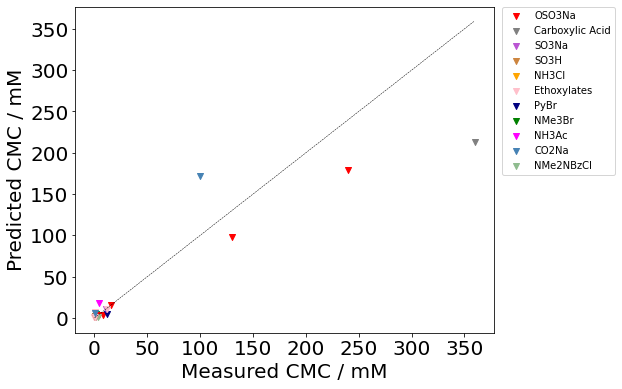

In [20]:
plot_meas_pred_test(600, 600, predictions, test_labels, test_ind, func_group, colours, "all_rf_test_meas_pred.png")

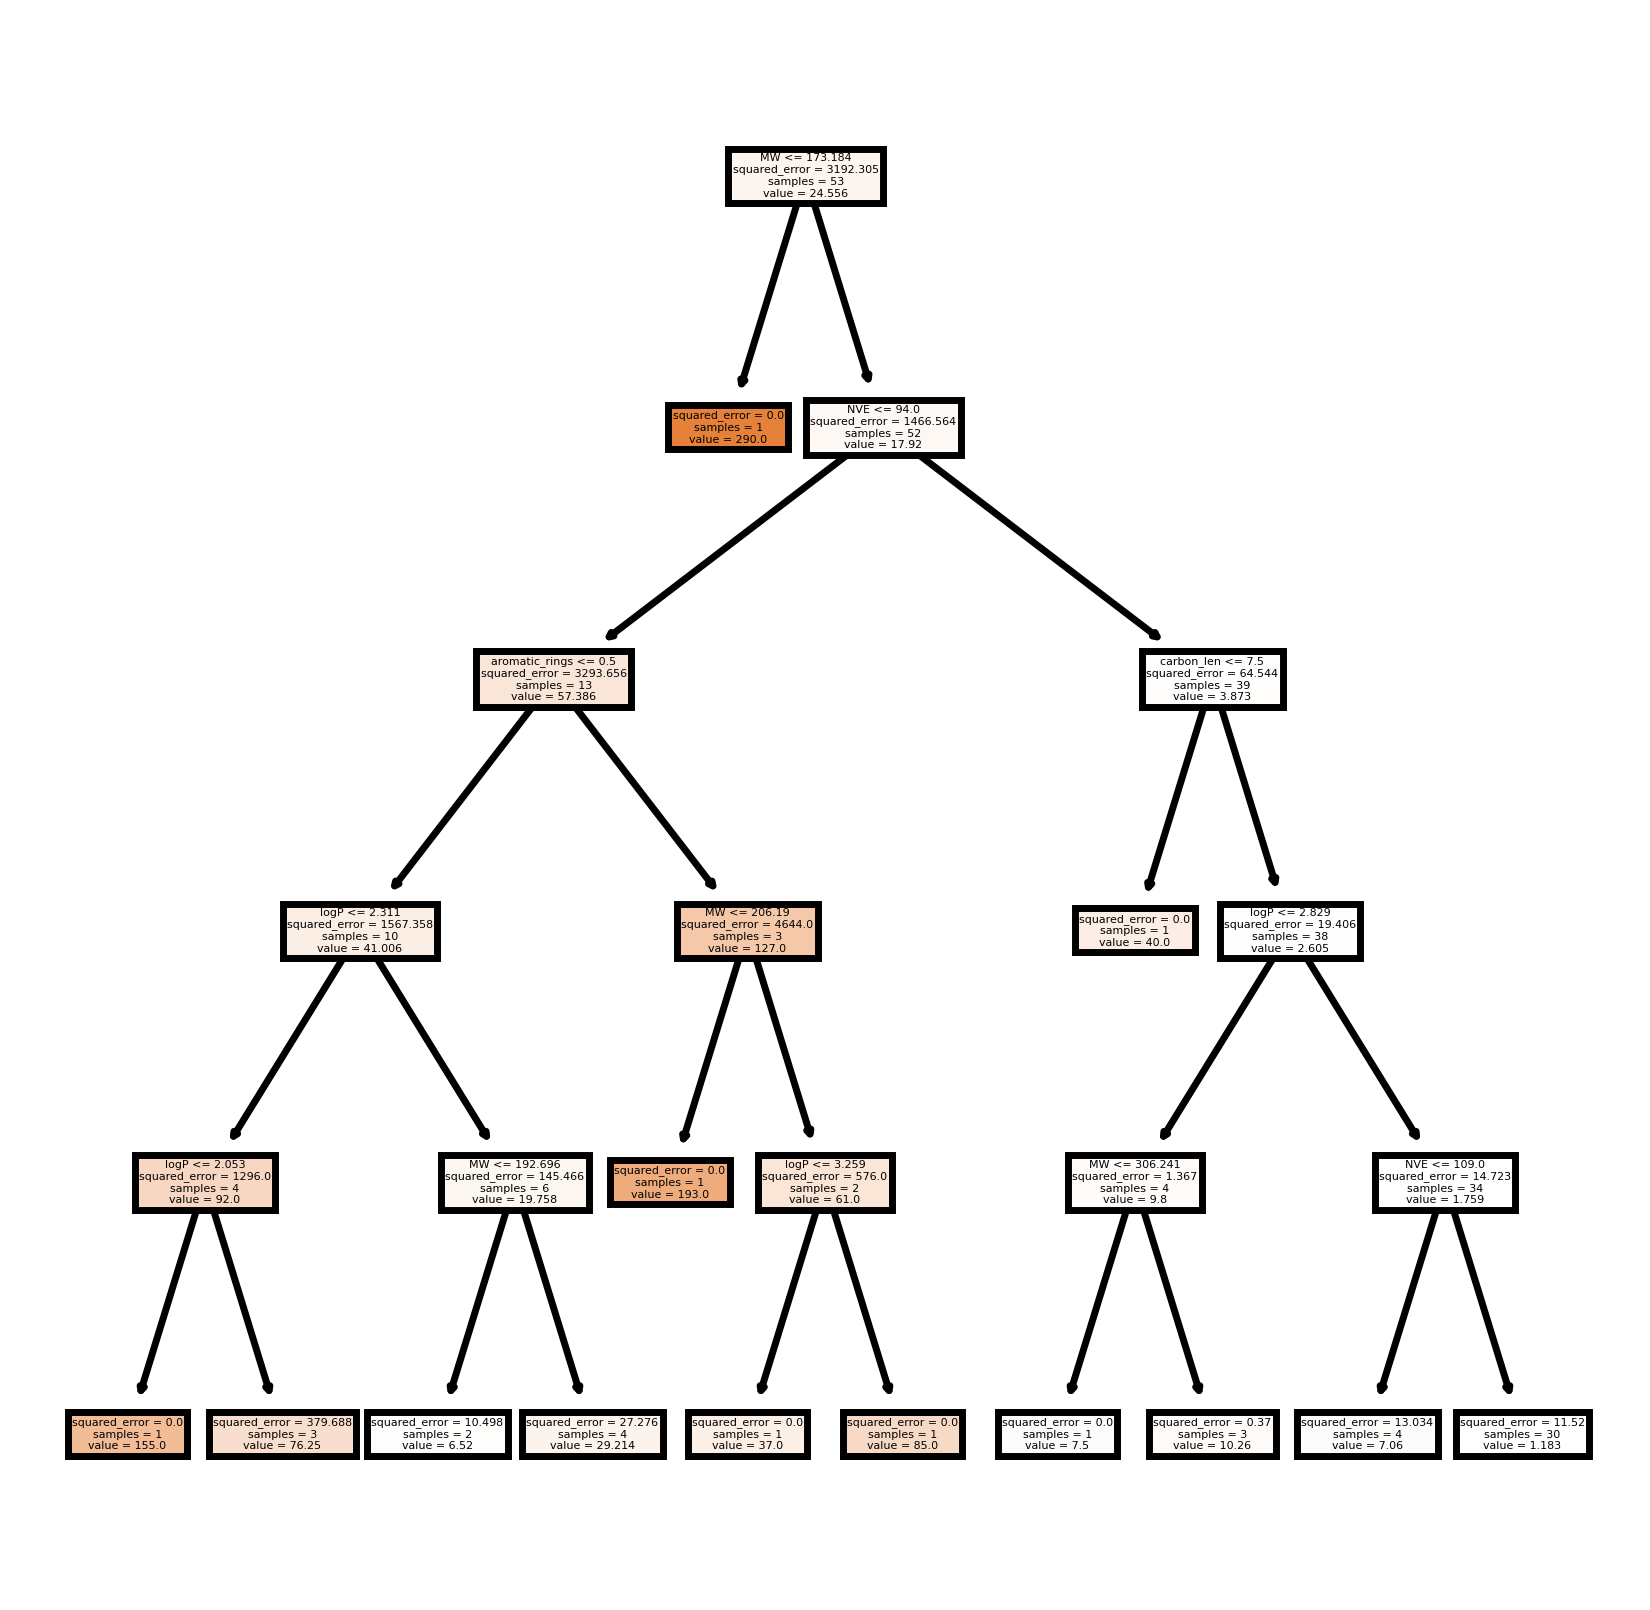

In [21]:
plot_rf(rf, feature_list, "rf_cmc.png", False)

*All data results*

This shows the MAE, RMSE and coefficient of determiniation of the random forest regression from the predictions using the all the data, including the data that was used to train the model. 

In [22]:
rf, feature_list, train_labels, test_labels, test_ind, indices, pred_all, errors_all, was_test = random_forest_results(cmc_data, False, True, False)


RMSE: 23.35
Coefficient of determination: 0.88
Mean Absolute Error: 9.0 mM 



*Plots all data*

This section plots the predicted CMC values from the random forest model against the measured ones, as well as showing the line which is the point where the predicted is equal to the measured (the ideal case where prediction is correct).

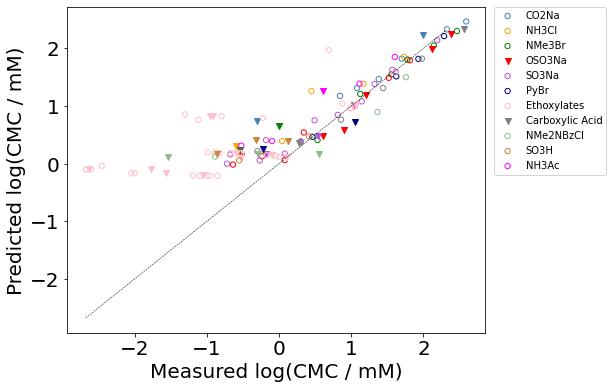

In [23]:
plot_meas_pred(600, 600, pred_all, true_cmc, indices, was_test, func_group, True, colours, 
               "all_rf_meas_pred_log.png", False)

*Variable importance plot*

Variable: NVE                  Importance: 0.4
Variable: logP                 Importance: 0.24
Variable: MW                   Importance: 0.23
Variable: carbon_len           Importance: 0.12
Variable: ethoxy_len           Importance: 0.01
Variable: aromatic_rings       Importance: 0.01


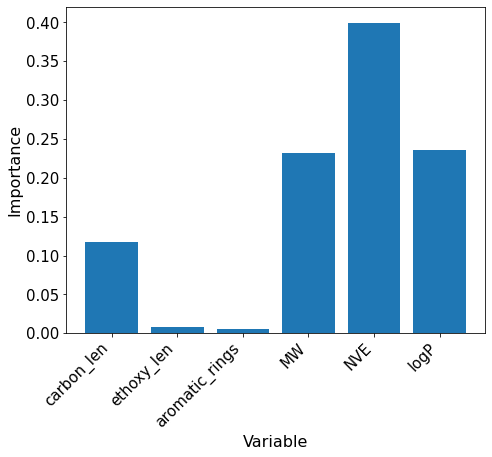

In [24]:
plot_var_importance(rf, feature_list, "all_rf_var_importance.png")

***Training Random Forest with all head groups except ethoxylates***

In [25]:
rf3_rmse, rf3_co_det, rf3_mae = rf_stats_average(data_sep, 0.7, False, False)

RMSE Mean:  39.63
Coeff of Det Mean:  0.67
MAE Mean:  19.92


RMSE Median:  37.53
Coeff of Det Median:  0.72
MAE Median:  0.72




*Test data results*

In [26]:
sep_rf, sep_feature_list, sep_train_labels, sep_test_labels, sep_test_ind, sep_indices, sep_predictions, sep_errors, sep_was_test = random_forest_results(data_sep, False, False, False)

RMSE: 52.06
Coefficient of determination: 0.75
Mean Absolute Error: 23.95 mM 



*Plots all data* 

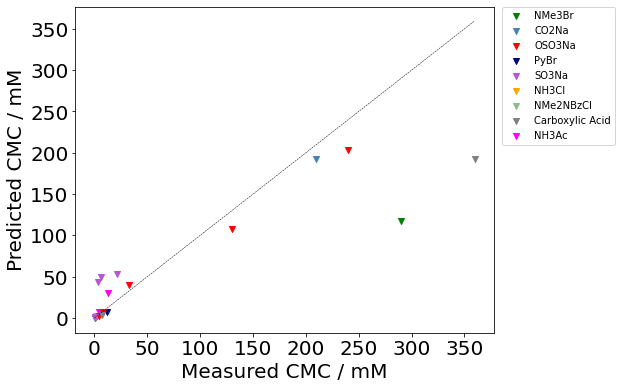

In [27]:
plot_meas_pred_test(600, 600, sep_predictions, sep_test_labels, sep_test_ind, func_group_sep, colours, 
                    "sep_rf_test_meas_pred.png")

*All data results*

In [28]:
sep_rf, sep_feature_list, sep_train_labels, sep_test_labels, sep_test_ind, sep_indices, sep_pred_all, sep_errors_all, sep_was_test = random_forest_results(data_sep, False, True, False)

RMSE: 31.7
Coefficient of determination: 0.84
Mean Absolute Error: 12.26 mM 



*Plots all data*

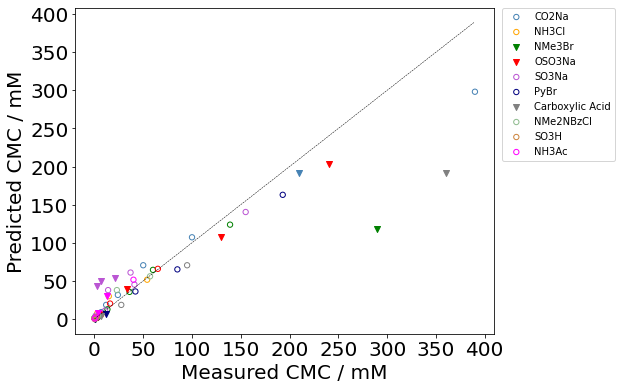

In [29]:
plot_meas_pred(600, 600, sep_pred_all, cmc_sep, sep_indices, sep_was_test, func_group_sep, False, colours, 
               "sep_rf_meas_pred.png", False)

*Variable importance plot*

Variable: carbon_len           Importance: 0.35
Variable: NVE                  Importance: 0.25
Variable: MW                   Importance: 0.22
Variable: logP                 Importance: 0.17
Variable: aromatic_rings       Importance: 0.01


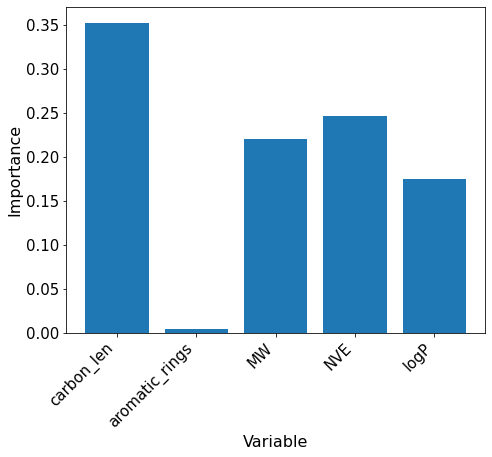

In [30]:
plot_var_importance(sep_rf, sep_feature_list, "sep_rf_var_importance.png")

### Using ln(CMC) values as the true solution

***Train random forest on all head groups***

In [31]:
rf4_rmse, rf4_co_det, rf4_mae = rf_stats_average(cmc_data, 0.7, False, True)

RMSE Mean:  38.21
Coeff of Det Mean:  0.63
MAE Mean:  14.45


RMSE Median:  37.58
Coeff of Det Median:  0.66
MAE Median:  0.66




*Test data results*

In [32]:
rf2, feature_list2, train_labels2, test_labels2, test_ind2, indices2, predictions2, errors2, was_test2 = random_forest_results(cmc_data, False, False, True)

RMSE: 31.72
Coefficient of determination: 0.81
Mean Absolute Error: 9.71 mM 



*Only plots test data*

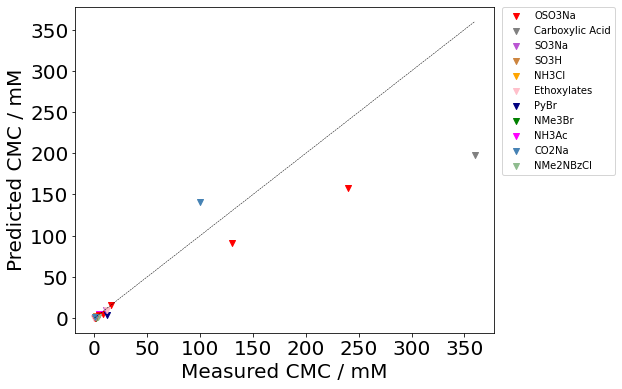

In [33]:
plot_meas_pred_test(600, 600, predictions2, test_labels2, test_ind2, func_group, colours, 
                    "all_rf_ln_meas_pred_test.png")

*All data results*

In [34]:
rf2, feature_list2, train_labels2, test_labels2, test_ind2, indices2, pred_all2, errors_all2, was_test2 = random_forest_results(cmc_data, False, True, True)

RMSE: 28.41
Coefficient of determination: 0.82
Mean Absolute Error: 9.44 mM 



*Plots all data*

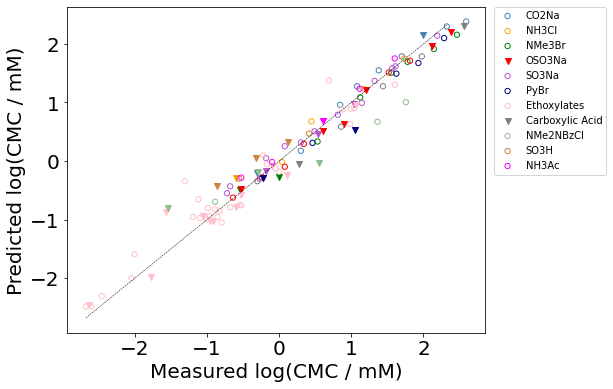

In [35]:
plot_meas_pred(600, 600, pred_all2, true_cmc, indices2, was_test2, func_group, True, colours, 
               "all_rf_ln_meas_pred_log.png", False)

*Variable importance plot*

Variable: NVE                  Importance: 0.36
Variable: MW                   Importance: 0.29
Variable: logP                 Importance: 0.19
Variable: carbon_len           Importance: 0.1
Variable: ethoxy_len           Importance: 0.05
Variable: aromatic_rings       Importance: 0.0


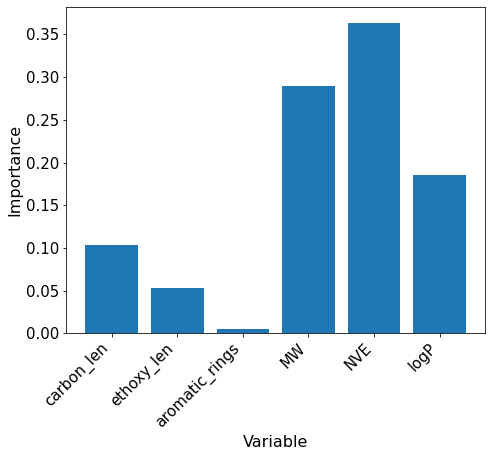

In [36]:
plot_var_importance(rf2, feature_list2, "all_rf_ln_var_importance.png")

***Training Random Forest with all head groups except ethoxylates***

In [37]:
rf6_rmse, rf6_co_det, rf6_mae = rf_stats_average(data_sep, 0.7, False, True)

RMSE Mean:  39.14
Coeff of Det Mean:  0.7
MAE Mean:  17.86


RMSE Median:  36.39
Coeff of Det Median:  0.74
MAE Median:  0.74




*Test data results*

In [38]:
sep_rf2, sep_feature_list2, sep_train_labels2, sep_test_labels2, sep_test_ind2, sep_indices2, sep_pred2, sep_errors2, sep_was_test2 = random_forest_results(data_sep, False, False, True)

RMSE: 51.51
Coefficient of determination: 0.75
Mean Absolute Error: 21.52 mM 



*Only plots test data* 

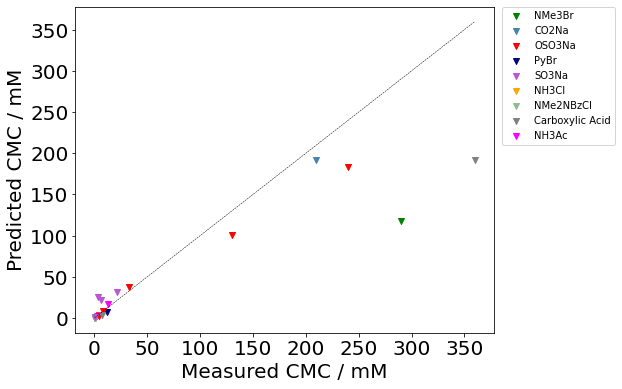

In [39]:
plot_meas_pred_test(600, 600, sep_pred2, sep_test_labels2, sep_test_ind2, func_group_sep, colours, 
                    "sep_rf_ln_test_meas_pred.png")

*All data results*

In [40]:
sep_rf2, sep_feature_list2, sep_train_labels2, sep_test_labels2, sep_test_ind2, sep_indices2, sep_pred_all2, sep_errors_all2, sep_was_test2 = random_forest_results(data_sep, False, True, True)

RMSE: 34.27
Coefficient of determination: 0.81
Mean Absolute Error: 12.47 mM 



*Plots all data* 

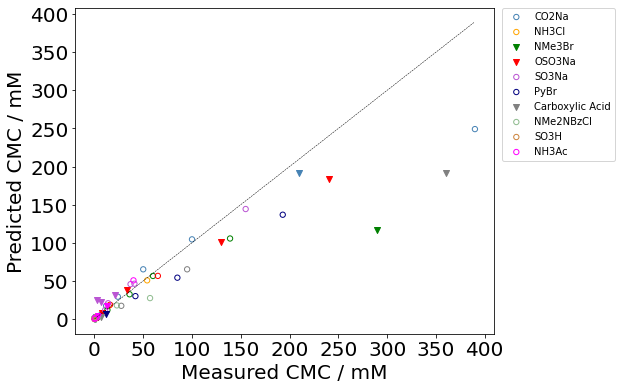

In [41]:
plot_meas_pred(600, 600, sep_pred_all2, cmc_sep, sep_indices2, sep_was_test2, func_group_sep, False, colours, 
               "sep_rf_ln_meas_pred.png", False)

*Variable importance plot*

Variable: carbon_len           Importance: 0.71
Variable: NVE                  Importance: 0.15
Variable: MW                   Importance: 0.07
Variable: logP                 Importance: 0.06
Variable: aromatic_rings       Importance: 0.0


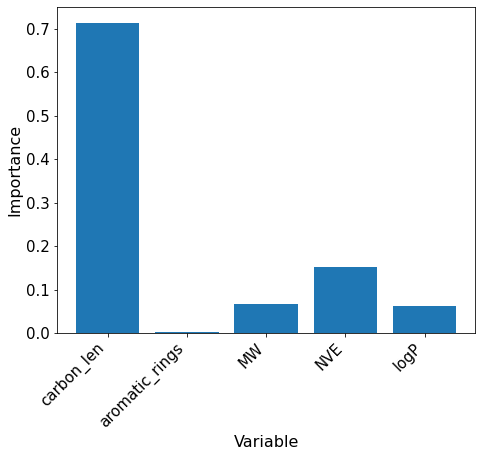

In [42]:
plot_var_importance(sep_rf2, sep_feature_list2, "sep_rf_ln_var_importance.png")

### Seeing how model performs with different features

***Previously excluded features***

In [43]:
# creates new pandas data frame using all data with other descriptors
data_feat = pd.DataFrame(true_cmc, columns = ["CMC"])
data_feat["ln(CMC)"] = log_cmc
data_feat["bertzct"] = bertzct_all
data_feat["wiener_index"] = wiener_index_all
data_feat["chi1"] = chi1_all
data_feat["chi0"] = chi0_all
data_feat["walk_count"] = walk_count_all
data_feat["labute_asa"] = labute_asa_all
data_feat["walk_count"] = walk_count_all
data_feat["peoe_vsa6"] = peoe_vsa6_all
data_feat["zagreb_index1"] = zagreb_index1_all
data_feat["zagreb_index2"] = zagreb_index2_all
data_feat["total_ic"] = total_ic_all

*Average statistics for predicting CMC*

In [44]:
rf7_rmse, rf7_co_det, rf7_mae = rf_stats_average(data_feat, 0.7, False, False)

RMSE Mean:  38.56
Coeff of Det Mean:  0.62
MAE Mean:  15.57


RMSE Median:  35.78
Coeff of Det Median:  0.69
MAE Median:  0.69




*Average statistics for predicting ln(CMC)*

In [45]:
rf8_rmse, rf8_co_det, rf8_mae = rf_stats_average(data_feat, 0.7, False, True)

RMSE Mean:  40.23
Coeff of Det Mean:  0.61
MAE Mean:  15.05


RMSE Median:  39.19
Coeff of Det Median:  0.66
MAE Median:  0.66




*Results from predicting CMC*

In [46]:
rf_feat, feature_list_feat, train_labels_feat, test_labels_feat, test_ind_feat, indices_feat, predictions_feat, errors_feat, was_test_feat = random_forest_results(data_feat, False, True, False)

RMSE: 24.28
Coefficient of determination: 0.87
Mean Absolute Error: 8.72 mM 



*Plots all data*

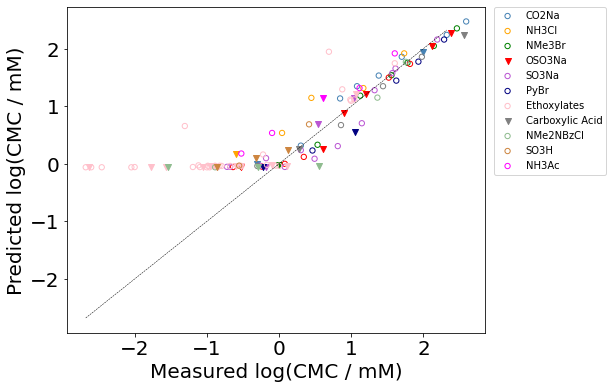

In [47]:
plot_meas_pred(600, 600, predictions_feat, true_cmc, indices_feat, was_test_feat, func_group, True, colours,
               "all_rf_meas_pred_feat_log.png", False)

*Results from predicting ln(CMC)*

In [48]:
rf_ln_feat, feature_list_ln_feat, train_labels_ln_feat, test_labels_ln_feat, test_ind_ln_feat, indices_ln_feat, predictions_ln_feat, errors_ln_feat, was_test_ln_feat = random_forest_results(data_feat, False, True, True)

RMSE: 32.04
Coefficient of determination: 0.77
Mean Absolute Error: 10.14 mM 



*Plots all data*

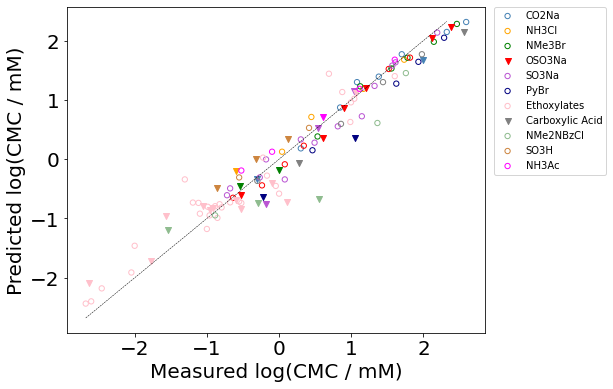

In [49]:
plot_meas_pred(600, 600, predictions_ln_feat, true_cmc, indices_ln_feat, was_test_ln_feat, func_group, True, colours,
               "all_rf_ln_meas_pred_feat_log.png", False)

*Variable importance plot*

Variable: total_ic             Importance: 0.24
Variable: peoe_vsa6            Importance: 0.19
Variable: wiener_index         Importance: 0.16
Variable: chi1                 Importance: 0.16
Variable: labute_asa           Importance: 0.09
Variable: bertzct              Importance: 0.05
Variable: chi0                 Importance: 0.05
Variable: zagreb_index2        Importance: 0.03
Variable: zagreb_index1        Importance: 0.02
Variable: walk_count           Importance: 0.01


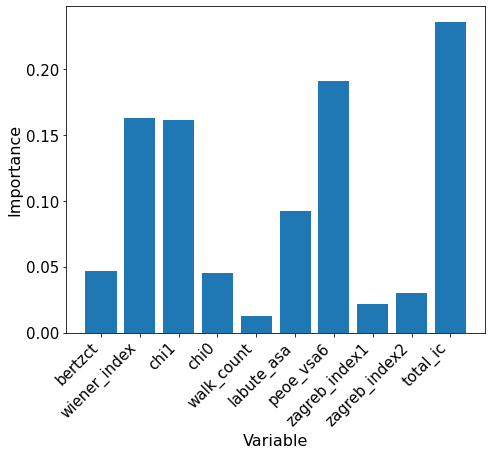

In [50]:
plot_var_importance(rf_feat, feature_list_feat, "all_rf_var_importance_feat.png")

***Using no logP, MW or NVE and instead using the head group information and counter ion***

In [51]:
# creates new pandas data frame using all data with fewer descriptors
data_feat2 = pd.DataFrame(true_cmc, columns = ["CMC"])
data_feat2["ln(CMC)"] = log_cmc
data_feat2["surfactant"] = func_group
data_feat2["carbon_len"] = carbon_len_all
data_feat2["ethoxy_len"] = ethoxy_length_all
data_feat2["aromatic_rings"] = aromatic_rings_all
data_feat2["counter_ion"] = counter_ion_all

*Average statistics for predicting CMC*

In [52]:
rf9_rmse, rf9_co_det, rf9_mae = rf_stats_average(data_feat2, 0.7, True, False)

RMSE Mean:  42.3
Coeff of Det Mean:  0.57
MAE Mean:  17.82


RMSE Median:  43.91
Coeff of Det Median:  0.6
MAE Median:  0.6




*Average statistics for predicting ln(CMC)*

In [53]:
rf10_rmse, rf10_co_det, rf10_mae = rf_stats_average(data_feat2, 0.7, True, True)

RMSE Mean:  37.78
Coeff of Det Mean:  0.67
MAE Mean:  14.12


RMSE Median:  35.51
Coeff of Det Median:  0.68
MAE Median:  0.68




*Results from predicting CMC*

In [54]:
rf_feat2, feature_list_feat2, train_labels_feat2, test_labels_feat2, test_ind_feat2, indices_feat2, predictions_feat2, errors_feat2, was_test_feat2 = random_forest_results(data_feat2, True, True, False)

RMSE: 31.35
Coefficient of determination: 0.78
Mean Absolute Error: 11.37 mM 



*Plots all data*

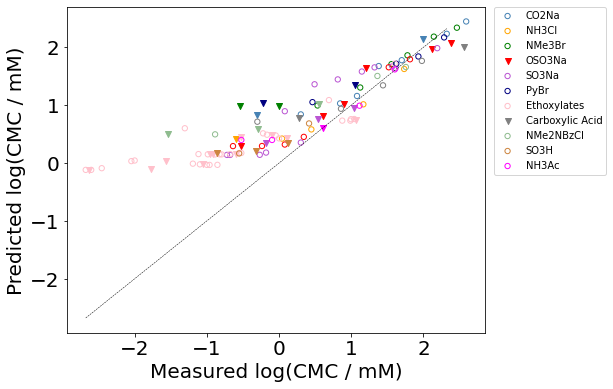

In [55]:
plot_meas_pred(600, 600, predictions_feat2, true_cmc, indices_feat2, was_test_feat2, func_group, True, colours,
               "all_rf_meas_pred_feat2_log.png", False)

*Results from predicting ln(CMC)*

In [56]:
rf_ln_feat2, feature_list_ln_feat2, train_labels_ln_feat2, test_labels_ln_feat2, test_ind_ln_feat2, indices_ln_feat2, predictions_ln_feat2, errors_ln_feat2, was_test_ln_feat2 = random_forest_results(data_feat2, True, True, True)

RMSE: 40.05
Coefficient of determination: 0.64
Mean Absolute Error: 12.28 mM 



*Plots all data*

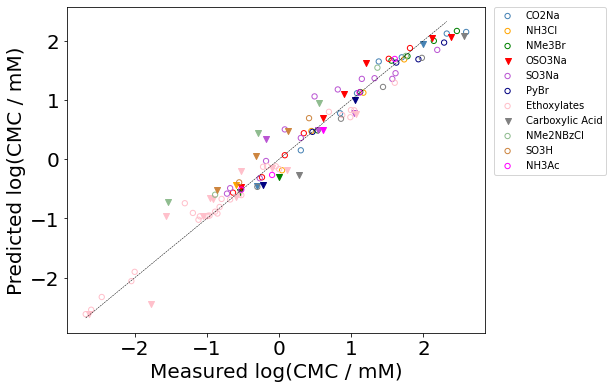

In [57]:
plot_meas_pred(600, 600, predictions_ln_feat2, true_cmc, indices_ln_feat2, was_test_ln_feat2, func_group, True, 
               colours, "all_rf_ln_meas_pred_feat2_log.png", False)

*Variable importance plot*

Variable: carbon_len           Importance: 0.48
Variable: surfactant_CO2Na     Importance: 0.15
Variable: counter_ion_Br-      Importance: 0.1
Variable: surfactant_NMe3Br    Importance: 0.06
Variable: aromatic_rings       Importance: 0.05
Variable: ethoxy_len           Importance: 0.04
Variable: surfactant_Ethoxylates Importance: 0.04
Variable: surfactant_PyBr      Importance: 0.04
Variable: surfactant_Carboxylic Acid Importance: 0.01
Variable: surfactant_SO3Na     Importance: 0.01
Variable: counter_ion_Na+      Importance: 0.01
Variable: surfactant_NH3Ac     Importance: 0.0
Variable: surfactant_NH3Cl     Importance: 0.0
Variable: surfactant_NMe2NBzCl Importance: 0.0
Variable: surfactant_OSO3Na    Importance: 0.0
Variable: surfactant_SO3H      Importance: 0.0
Variable: counter_ion_Ac-      Importance: 0.0
Variable: counter_ion_Cl-      Importance: 0.0
Variable: counter_ion_H+       Importance: 0.0


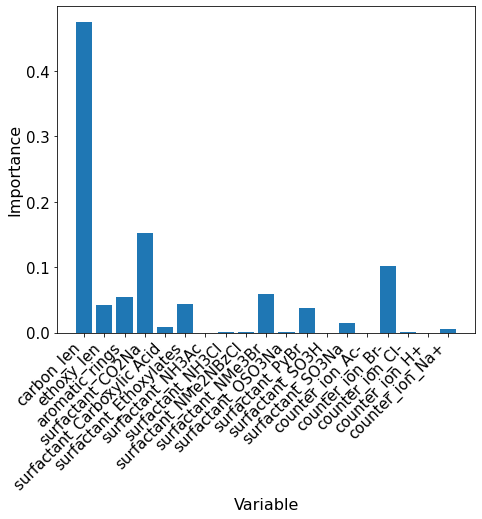

In [58]:
plot_var_importance(rf_feat2, feature_list_feat2, "all_rf_ln_var_importance_feat2.png")

### Removing whole head group to see how model is able to predict an unseen head group

***CO2Na***

*Train with CMC*

RMSE: 57.65
Coefficient of determination: 0.79
Mean Absolute Error: 41.77 mM 



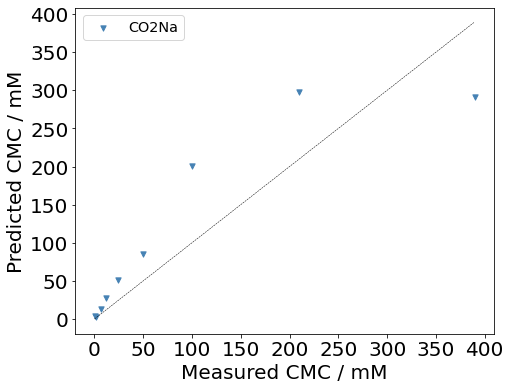

In [59]:
co2na_test_labels, co2na_test_ind, co2na_pred = separate_random_forest(cmc_data, 0, 8, False, True, False)

plot_meas_pred_single(600, 600, co2na_pred, co2na_test_labels, co2na_test_ind, "CO2Na", colours,
                      "test_co2na_rf_meas_pred.png")

*Train with ln(CMC)*

RMSE: 52.56
Coefficient of determination: 0.82
Mean Absolute Error: 34.8 mM 



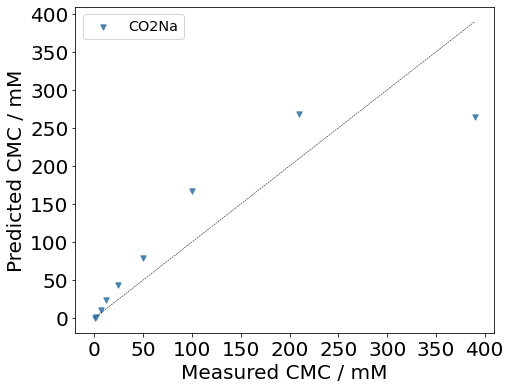

In [60]:
co2na_ln_test_labels, co2na_ln_test_ind, co2na_ln_pred = separate_random_forest(cmc_data, 0, 8, False, True, True)

plot_meas_pred_single(600, 600, co2na_ln_pred, co2na_ln_test_labels, co2na_ln_test_ind, "CO2Na", colours,
                      "test_co2na_ln_rf_meas_pred.png")

***NH3Cl***

*Train with CMC*

RMSE: 20.9
Coefficient of determination: -0.05
Mean Absolute Error: 15.4 mM 



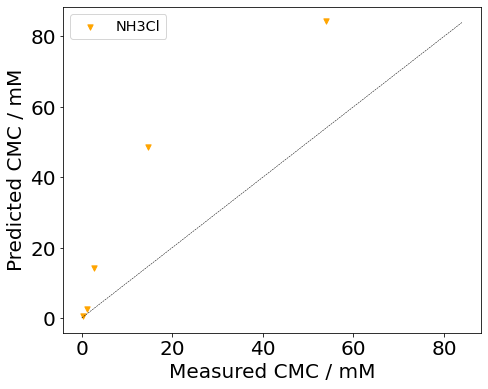

In [61]:
nh3cl_test_labels, nh3cl_test_ind, nh3cl_pred = separate_random_forest(cmc_data, 9, 13, False, True, False)

plot_meas_pred_single(600, 600, nh3cl_pred, nh3cl_test_labels, nh3cl_test_ind, "NH3Cl", colours,
                      "test_nh3cl_rf_meas_pred.png")

*Train with ln(CMC)*

RMSE: 2.25
Coefficient of determination: 0.99
Mean Absolute Error: 1.48 mM 



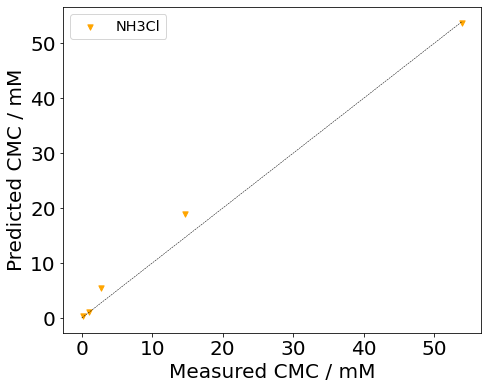

In [62]:
nh3cl_ln_test_labels, nh3cl_ln_test_ind, nh3cl_ln_pred = separate_random_forest(cmc_data, 9, 13, False, True, True)

plot_meas_pred_single(600, 600, nh3cl_ln_pred, nh3cl_ln_test_labels, nh3cl_ln_test_ind, "NH3Cl", colours,
                      "test_nh3cl_ln_rf_meas_pred.png")

***NMe3Br***

*Train with CMC*

RMSE: 82.01
Coefficient of determination: 0.25
Mean Absolute Error: 39.86 mM 



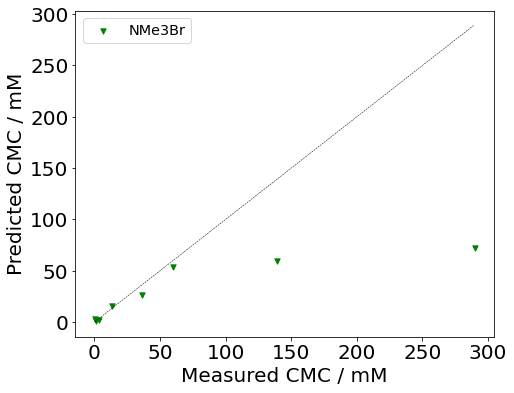

In [63]:
nme3br_test_labels, nme3br_test_ind, nme3br_pred = separate_random_forest(cmc_data, 14, 21, False, True, False)

plot_meas_pred_single(600, 600, nme3br_pred, nme3br_test_labels, nme3br_test_ind, "NMe3Br", colours,
                      "test_nme3br_rf_meas_pred.png")

*ln(CMC)*

RMSE: 92.85
Coefficient of determination: 0.04
Mean Absolute Error: 48.03 mM 



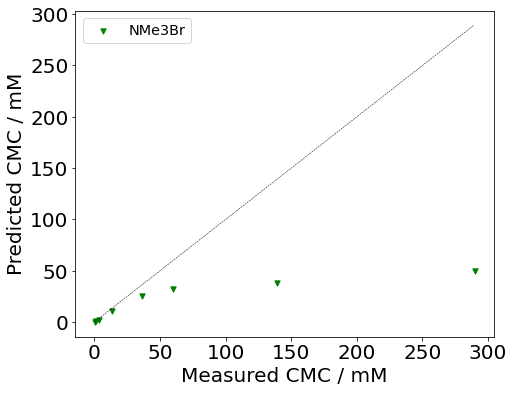

In [64]:
nme3br_ln_test_labels, nme3br_ln_test_ind, nme3br_ln_pred = separate_random_forest(cmc_data, 14, 21, False, True, 
                                                                                True)

plot_meas_pred_single(600, 600, nme3br_ln_pred, nme3br_ln_test_labels, nme3br_ln_test_ind, "NMe3Br", colours,
                      "test_nme3br_ln_rf_meas_pred.png")

***OSO3Na***

*Train with CMC*

RMSE: 17.17
Coefficient of determination: 0.94
Mean Absolute Error: 8.41 mM 



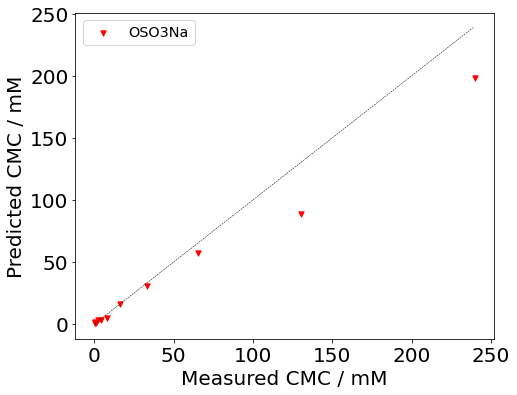

In [65]:
oso3na_test_labels, oso3na_test_ind, oso3na_pred = separate_random_forest(cmc_data, 22, 33, False, True, False)

plot_meas_pred_single(600, 600, oso3na_pred, oso3na_test_labels, oso3na_test_ind, "OSO3Na", colours,
                      "test_oso3na_rf_meas_pred.png")

*ln(CMC)*

RMSE: 23.05
Coefficient of determination: 0.89
Mean Absolute Error: 10.3 mM 



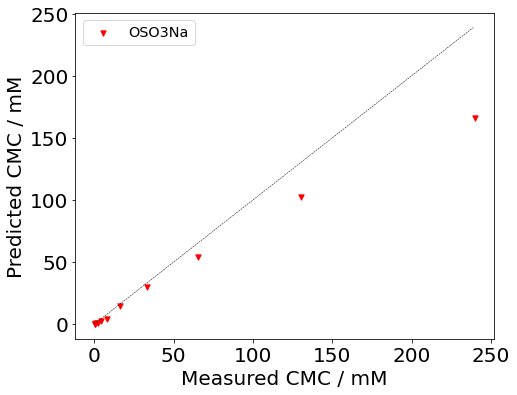

In [66]:
oso3na_ln_test_labels, oso3na_ln_test_ind, oso3na_ln_pred = separate_random_forest(cmc_data, 22, 33, False, True, 
                                                                                True)

plot_meas_pred_single(600, 600, oso3na_ln_pred, oso3na_ln_test_labels, oso3na_ln_test_ind, "OSO3Na", colours,
                      "test_oso3na_ln_rf_meas_pred.png")

***SO3Na***

*Train with CMC*

RMSE: 8.04
Coefficient of determination: 0.95
Mean Absolute Error: 5.39 mM 



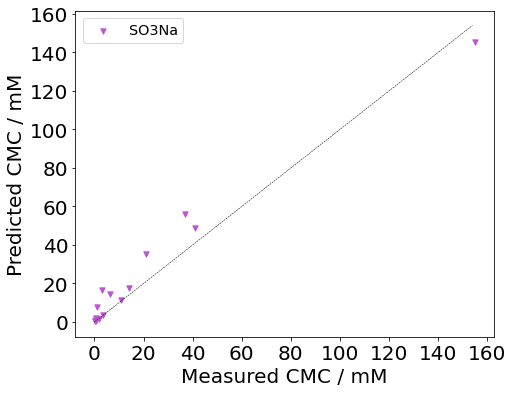

In [67]:
so3na_test_labels, so3na_test_ind, so3na_pred = separate_random_forest(cmc_data, 34, 49, False, True, False)\

plot_meas_pred_single(600, 600, so3na_pred, so3na_test_labels, so3na_test_ind, "SO3Na", colours,
                      "test_so3na_rf_meas_pred.png")

*ln(CMC)*

RMSE: 13.6
Coefficient of determination: 0.87
Mean Absolute Error: 6.43 mM 



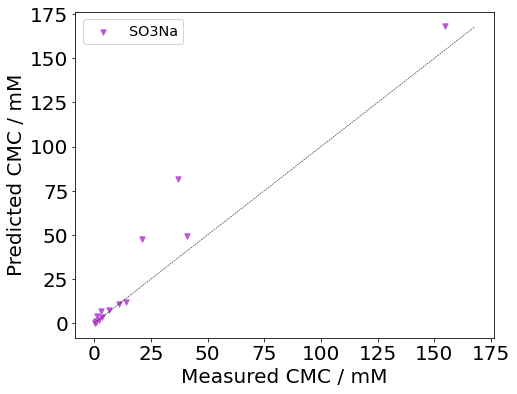

In [68]:
so3na_ln_test_labels, so3na_ln_test_ind, so3na_ln_pred = separate_random_forest(cmc_data, 34, 49, False, True, 
                                                                                True)

plot_meas_pred_single(600, 600, so3na_ln_pred, so3na_ln_test_labels, so3na_ln_test_ind, "SO3Na", colours,
                      "test_so3na_ln_rf_meas_pred.png")

***PyBr***

*Train with CMC*

RMSE: 36.78
Coefficient of determination: 0.71
Mean Absolute Error: 25.03 mM 



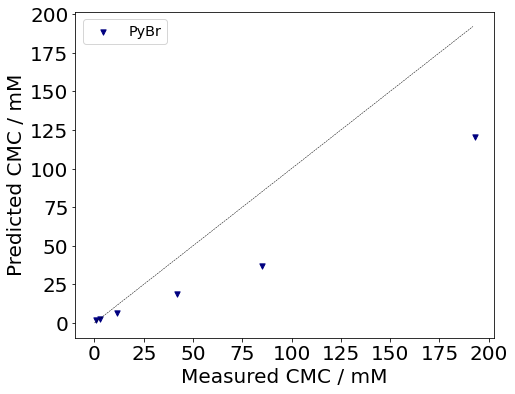

In [69]:
pybr_test_labels, pybr_test_ind, pybr_pred = separate_random_forest(cmc_data, 50, 55, False, True, False)

plot_meas_pred_single(600, 600, pybr_pred, pybr_test_labels, pybr_test_ind, "PyBr", colours,
                      "test_pybr_rf_meas_pred.png")

*ln(CMC)*

RMSE: 53.48
Coefficient of determination: 0.38
Mean Absolute Error: 34.07 mM 



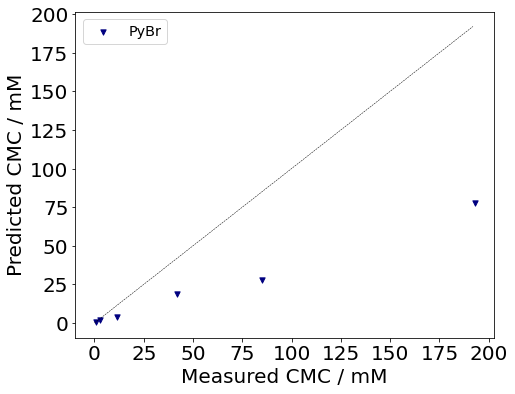

In [70]:
pybr_ln_test_labels, pybr_ln_test_ind, pybr_ln_pred = separate_random_forest(cmc_data, 50, 55, False, True, 
                                                                                True)

plot_meas_pred_single(600, 600, pybr_ln_pred, pybr_ln_test_labels, pybr_ln_test_ind, "PyBr", colours,
                      "test_pybr_ln_rf_meas_pred.png")

***Ethoxylates***

*Train with CMC*

RMSE: 39.53
Coefficient of determination: -32.4
Mean Absolute Error: 23.36 mM 



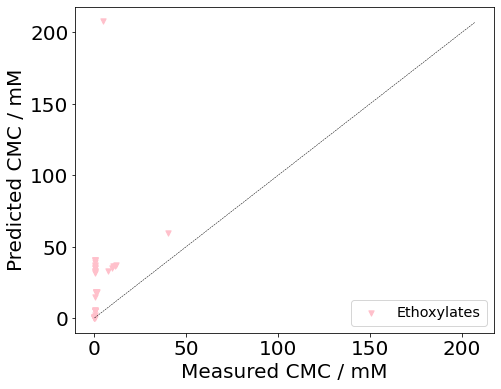

In [71]:
ethoxy_test_labels, ethoxy_test_ind, ethoxy_pred = separate_random_forest(cmc_data, 56, 95, False, True, False)

plot_meas_pred_single(600, 600, ethoxy_pred, ethoxy_test_labels, ethoxy_test_ind, "Ethoxylates", colours,
                      "test_ethoxy_rf_meas_pred.png")

*ln(CMC)*

RMSE: 28.96
Coefficient of determination: -16.93
Mean Absolute Error: 9.53 mM 



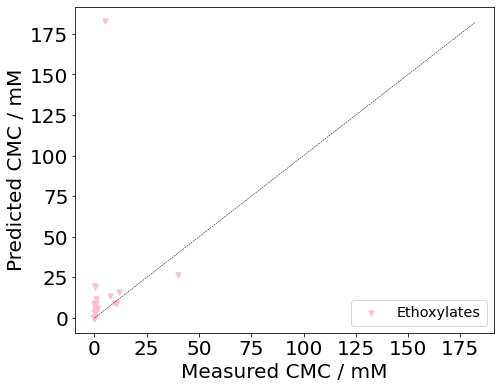

In [72]:
ethoxy_ln_test_labels, ethoxy_ln_test_ind, ethoxy_ln_pred = separate_random_forest(cmc_data, 56, 95, False, True, 
                                                                                True)

plot_meas_pred_single(600, 600, ethoxy_ln_pred, ethoxy_ln_test_labels, ethoxy_ln_test_ind, "Ethoxylates", colours,
                      "test_ethoxy_ln_rf_meas_pred.png")

***Carboxylic Acids***

*Train with CMC*

RMSE: 60.08
Coefficient of determination: 0.78
Mean Absolute Error: 32.11 mM 



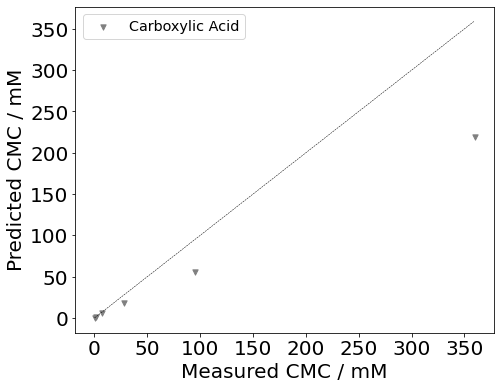

In [73]:
ca_test_labels, ca_test_ind, ca_pred = separate_random_forest(cmc_data, 96, 101, False, True, False)

plot_meas_pred_single(600, 600, ca_pred, ca_test_labels, ca_test_ind, "Carboxylic Acid", colours,
                      "test_carbacid_rf_meas_pred.png")

*ln(CMC)*

RMSE: 58.37
Coefficient of determination: 0.79
Mean Absolute Error: 33.05 mM 



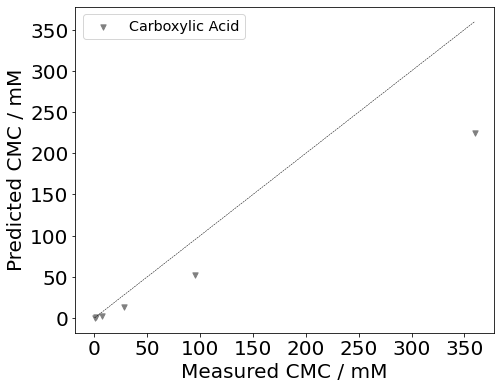

In [74]:
ca_ln_test_labels, ca_ln_test_ind, ca_ln_pred = separate_random_forest(cmc_data, 96, 101, False, True, True)

plot_meas_pred_single(600, 600, ca_ln_pred, ca_ln_test_labels, ca_ln_test_ind, "Carboxylic Acid", colours,
                      "test_carbacid_ln_rf_meas_pred.png")

***NMe2NBzCl***

*Train with CMC*

RMSE: 24.58
Coefficient of determination: -0.39
Mean Absolute Error: 13.62 mM 



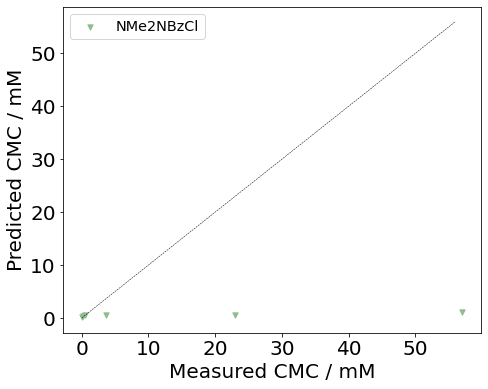

In [75]:
nme2nbzcl_test_labels, nme2nbzcl_test_ind, nme2nbzcl_pred = separate_random_forest(cmc_data, 102, 107, False, 
                                                                                   True, False)

plot_meas_pred_single(600, 600, nme2nbzcl_pred, nme2nbzcl_test_labels, nme2nbzcl_test_ind, "NMe2NBzCl", colours,
                      "test_NMe2NBzCl_rf_meas_pred.png")

*ln(CMC)*

RMSE: 24.76
Coefficient of determination: -0.41
Mean Absolute Error: 13.64 mM 



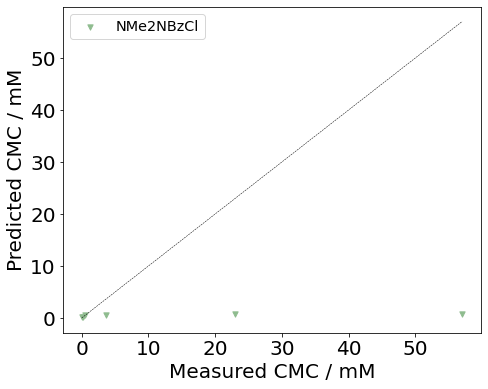

In [76]:
nme2nbzcl_ln_test_labels, nme2nbzcl_ln_test_ind, nme2nbzcl_ln_pred = separate_random_forest(cmc_data, 102, 107, 
                                                                                            False, True, True)

plot_meas_pred_single(600, 600, nme2nbzcl_ln_pred, nme2nbzcl_ln_test_labels, nme2nbzcl_ln_test_ind, "NMe2NBzCl", colours,
                      "test_NMe2NBzCl_ln_rf_meas_pred.png")

***SO3H***

*Train with CMC*

RMSE: 1.07
Coefficient of determination: -0.38
Mean Absolute Error: 1.02 mM 



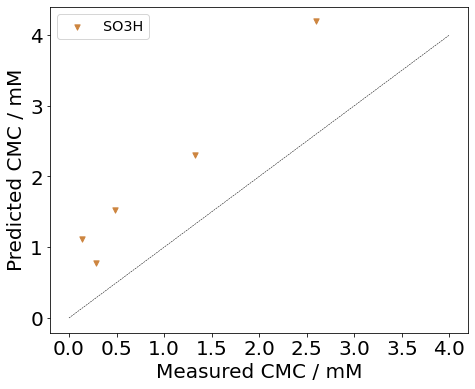

In [77]:
so3h_test_labels, so3h_test_ind, so3h_pred = separate_random_forest(cmc_data, 108, 112, False, True, False)

plot_meas_pred_single(600, 600, so3h_pred, so3h_test_labels, so3h_test_ind, "SO3H", colours,
                      "test_S03H_rf_meas_pred.png")

*ln(CMC)*

RMSE: 0.81
Coefficient of determination: 0.22
Mean Absolute Error: 0.64 mM 



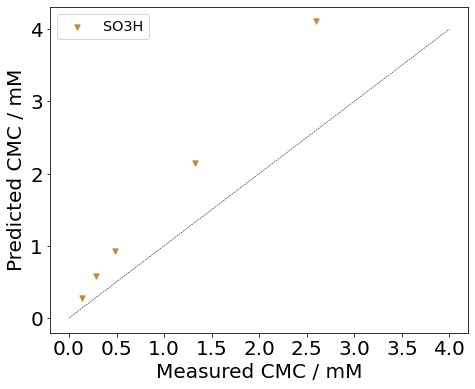

In [78]:
so3h_ln_test_labels, so3h_ln_test_ind, so3h_ln_pred = separate_random_forest(cmc_data, 108, 112, False, True, True)

plot_meas_pred_single(600, 600, so3h_ln_pred, so3h_ln_test_labels, so3h_ln_test_ind, "SO3H", colours,
                      "test_SO3H_ln_rf_meas_pred.png")

***NH3Ac***

*Train with CMC*

RMSE: 27.8
Coefficient of determination: -2.48
Mean Absolute Error: 20.13 mM 



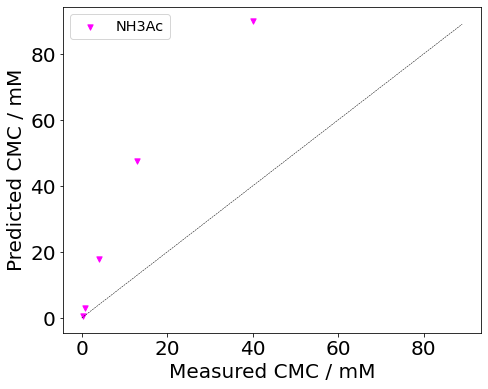

In [79]:
nh3ac_test_labels, nh3ac_test_ind, nh3ac_pred = separate_random_forest(cmc_data, 113, 117, False, True, False)

plot_meas_pred_single(600, 600, nh3ac_pred, nh3ac_test_labels, nh3ac_test_ind, "NH3Ac", colours,
                      "test_NH3Ac_rf_meas_pred.png")

*ln(CMC)*

RMSE: 11.11
Coefficient of determination: 0.44
Mean Absolute Error: 6.72 mM 



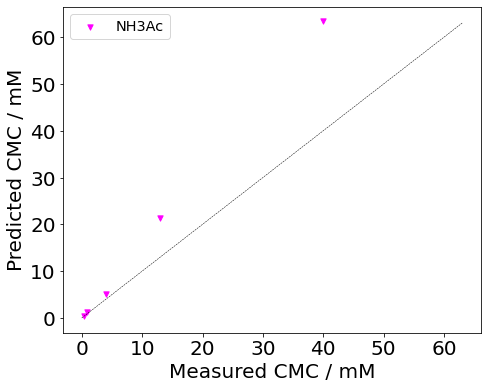

In [80]:
nh3ac_ln_test_labels, nh3ac_ln_test_ind, nh3ac_ln_pred = separate_random_forest(cmc_data, 113, 117, False, 
                                                                                True, True)

plot_meas_pred_single(600, 600, nh3ac_ln_pred, nh3ac_ln_test_labels, nh3ac_ln_test_ind, "NH3Ac", colours,
                      "test_NH3Ac_ln_rf_meas_pred.png")

***Combining predictions for each head group to plot***

In [81]:
# predictions made of CMC
all_test = [True for ind in range(len(cmc_data))]

pred_unseen_cmc_sep = []
pred_unseen_cmc_sep.append(co2na_pred); pred_unseen_cmc_sep.append(nh3cl_pred)
pred_unseen_cmc_sep.append(nme3br_pred); pred_unseen_cmc_sep.append(oso3na_pred)
pred_unseen_cmc_sep.append(so3na_pred); pred_unseen_cmc_sep.append(pybr_pred)
pred_unseen_cmc_sep.append(ethoxy_pred); pred_unseen_cmc_sep.append(ca_pred)
pred_unseen_cmc_sep.append(nme2nbzcl_pred); pred_unseen_cmc_sep.append(so3h_pred)
pred_unseen_cmc_sep.append(nh3ac_pred)

# predictions made of ln(CMC)
pred_unseen_cmc = list(chain.from_iterable(pred_unseen_cmc_sep))

pred_unseen_ln_cmc_sep = []
pred_unseen_ln_cmc_sep.append(co2na_ln_pred); pred_unseen_ln_cmc_sep.append(nh3cl_ln_pred)
pred_unseen_ln_cmc_sep.append(nme3br_ln_pred); pred_unseen_ln_cmc_sep.append(oso3na_ln_pred)
pred_unseen_ln_cmc_sep.append(so3na_ln_pred); pred_unseen_ln_cmc_sep.append(pybr_ln_pred)
pred_unseen_ln_cmc_sep.append(ethoxy_ln_pred); pred_unseen_ln_cmc_sep.append(ca_ln_pred)
pred_unseen_ln_cmc_sep.append(nme2nbzcl_ln_pred); pred_unseen_ln_cmc_sep.append(so3h_ln_pred)
pred_unseen_ln_cmc_sep.append(nh3ac_ln_pred)

pred_unseen_ln_cmc = list(chain.from_iterable(pred_unseen_ln_cmc_sep))

*CMC*

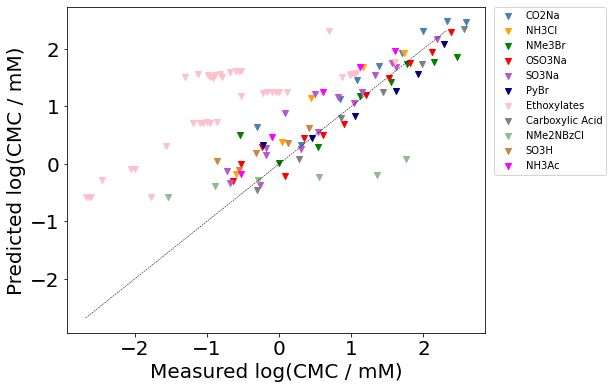

In [82]:
plot_meas_pred(600, 600, pred_unseen_cmc, true_cmc, indices, all_test, func_group, True, colours, 
               "pred_unseen_all_pred_meas_log.png", False)

*ln(CMC)*

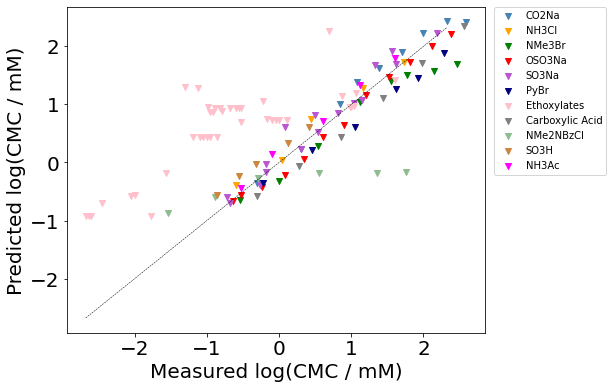

In [83]:
plot_meas_pred(600, 600, pred_unseen_ln_cmc, true_cmc, indices, all_test, func_group, True, colours, 
               "pred_unseen_all_ln_pred_meas_log.png", False)